In [1]:
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from matplotlib.dates import DayLocator ,MonthLocator, DateFormatter, WeekdayLocator
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler, OneHotEncoder
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from scipy.stats import zscore, pearsonr
import ruptures as rpt
import random
from statsmodels.tsa.stattools import acf, pacf
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score
from sklearn.svm import OneClassSVM
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Dataset - Basic Formatting

Loaded the dataset and dropping redundant ID column

In [2]:
# Load dataset and navigate to the correct directory.
lloyds_dataset_core = pd.read_csv("Lloyds_data.csv")
df = lloyds_dataset_core.copy()

In [3]:
# DATA FORMATTING - Redundant unnamed column removal.
try:
    df = df.drop('Unnamed: 0', axis = 1)
except Exception as e:
    print("Sequence Numbering column already dropped.")

In [4]:
# DATA FORMATTING

# Step1: Convert date from string to datetime format
# Step2: Convert hour_of_day into integer format.
# Step3: Generate timestamp in ISO8601 compliant format.
# Step3: Sort by employee and event timestamp to construct meaningful time-series.

df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df['day_of_week'] = df['date'].dt.weekday

if 'hour_of_day' in df.columns: 
    df.rename(columns={'hour_of_day': 'hour_of_day_orig'}, inplace=True)
df['hour_of_day'] = df['hour_of_day_orig'].astype(int)

df['timestamp_iso8601'] = df.apply(
    lambda row: (row['date'] + pd.Timedelta(hours=row['hour_of_day'])).isoformat(),
    axis=1
)
df['timestamp_iso8601'] = pd.to_datetime(df['timestamp_iso8601'])

try:
    df.drop(columns=['hour_of_day_orig', 'timestamp'], inplace=True)
except Exception as e:
    print("Redundant timestamp and hour_of_day_orig columns already dropped.")

df = df[['individual_id', 'timestamp_iso8601', 'date', 'day_of_week', 'hour_of_day', 'department', 'spend', 'at_risk_event', 'at_risk_behaviour_window']]
df = df.sort_values(by = ['individual_id', 'timestamp_iso8601'])

# EDA

## Auxiliary Functions for dataframe aggregation, scaling and correlation calculation

In [5]:
def scale(agg):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(agg)
    scaled_agg = pd.DataFrame(scaled_data, columns=agg.columns)
    scaled_agg.set_index(agg.index, inplace=True)
    return scaled_agg

In [178]:
import pandas as pd
from scipy.stats import pearsonr

def correlation_plot_and_value(agg, label, plot = 1):
    agg = (lambda x: x.copy())(agg)
    
    if plot == 1:
        plt.figure(figsize=(7, 1))
        plt.plot(agg.index, agg['risk_ratio'], label='Risk Ratio', marker='o', linestyle='-')
        plt.plot(agg.index, agg['mean_spend'], label='Mean Spending', marker='s', linestyle='-')
        plt.title('Mean spend vs Risk Ratio', fontsize=16)
        plt.xlabel(label, fontsize=16)
        plt.ylabel('Scaled Values', fontsize=16)
        plt.legend(title='Legend')
        plt.xticks(rotation=20)
        plt.grid(True)
        plt.show()

    corr_matrix = agg.corr()
    risk_corr = corr_matrix['risk_ratio'].drop('risk_ratio')    
    p_values = {}
    for col in risk_corr.index:
        corr, p_value = pearsonr(agg[col], agg['risk_ratio'])
        p_values[col] = p_value
    
    results = pd.DataFrame({'Correlation w.r.t Risk Ratio': risk_corr, 'P-value': p_values})
    alpha = 0.05 # significance threshold
    results['significant'] = results['P-value'] <= alpha    
    results = results.sort_values(by='Correlation w.r.t Risk Ratio', ascending=False)
    return results[results['significant'] == True]

## Data Aberrations

In [7]:
# Null checking
df.isnull().sum()

individual_id                    0
timestamp_iso8601                0
date                             0
day_of_week                      0
hour_of_day                      0
department                       0
spend                            0
at_risk_event                    0
at_risk_behaviour_window    101229
dtype: int64

In [8]:
# Zero spend rows (?)
len(df[df['spend'] == 0])

35

In [9]:
# Remove all zero spend rows
if len(df[df['spend'] == 0]) != 0:
    df = df[df['spend'] != 0].reset_index(drop=True)
else:
    print("Transactions with zero spend already removed.")

In [10]:
df

,individual_id,timestamp_iso8601,date,day_of_week,hour_of_day,department,spend,at_risk_event,at_risk_behaviour_window
0,1,2023-01-09 11:00:00,2023-01-09,0,11,ops,2.10,False,NaN
1,1,2023-01-11 09:00:00,2023-01-11,2,9,ops,4.45,False,NaN
2,1,2023-01-12 08:00:00,2023-01-12,3,8,ops,3.94,False,NaN
3,1,2023-01-12 10:00:00,2023-01-12,3,10,ops,2.72,False,NaN
4,1,2023-01-12 13:00:00,2023-01-12,3,13,ops,1.50,False,NaN
...,...,...,...,...,...,...,...,...,...
105237,2184,2023-04-20 12:00:00,2023-04-20,3,12,finance,8.91,False,NaN
105238,2184,2023-04-21 10:00:00,2023-04-21,4,10,finance,20.24,False,NaN
105239,2184,2023-04-24 17:00:00,2023-04-24,0,17,finance,12.25,False,NaN
105240,2185,2023-02-08 12:00:00,2023-02-08,2,12,investor_relations,15.68,False,NaN


## Uniqueness Analysis

In [11]:
print("Unique employees: ", df['individual_id'].unique(), " - ", len(df['individual_id'].unique()))
print("Unique dates: ", df['date'].unique(), " - ", len(df['date'].unique()))
print("Unique days of week: ", df['day_of_week'].unique(), " - ", len(df['day_of_week'].unique()))
print("Unique hours of day: ", df['hour_of_day'].unique(), " - ", len(df['hour_of_day'].unique()))
print("Unique departments: ", df['department'].unique(), " - ", len(df['department'].unique()))

Unique employees:  [   1    2    3 ... 2183 2184 2185]  -  2185
Unique dates:  <DatetimeArray>
['2023-01-09 00:00:00', '2023-01-11 00:00:00', '2023-01-12 00:00:00',
 '2023-01-13 00:00:00', '2023-01-15 00:00:00', '2023-01-16 00:00:00',
 '2023-01-17 00:00:00', '2023-01-18 00:00:00', '2023-01-19 00:00:00',
 '2023-01-20 00:00:00',
 ...
 '2023-03-19 00:00:00', '2023-04-09 00:00:00', '2023-04-15 00:00:00',
 '2023-01-22 00:00:00', '2023-02-11 00:00:00', '2023-04-23 00:00:00',
 '2023-02-25 00:00:00', '2023-04-30 00:00:00', '2023-04-02 00:00:00',
 '2023-04-29 00:00:00']
Length: 111, dtype: datetime64[ns]  -  111
Unique days of week:  [0 2 3 4 6 1 5]  -  7
Unique hours of day:  [11  9  8 10 13 15 12 14 16 17  7  0  3 18 19 20  6 21  5  2  4 22  1 23]  -  24
Unique departments:  ['ops' 'finance' 'product_management' 'legal' 'risk' 'development'
 'quality_assurance' 'general' 'technology' 'it' 'sourcing' 'marketing'
 'production' 'sales' 'strategy' 'accounting' 'human_resources'
 'investor_relatio

#### Conclusions, Insights and Actions

Conclusions:

At an organisational level, there are:

1. 2185 unique employees
2. Data present for 111 days - from 2023-01-09 to 2023-04-09
3. Data present for all weekdays.
4. Data present for all hours.
5. 20 unique departments.

## Aggregate Analysis - individual_id, date, day_of_week, hour_of_day

In [12]:
# individual_id
emp_agg = df.groupby('individual_id').agg({
    'spend': [('mean_spend', 'mean'), ('total_spending', 'sum')],  # Total spending
    'at_risk_event': [('risky_events', lambda x: (x == True).sum()), ('total_events', 'count')],  # Total events and Count of risky events
})
emp_agg.columns = [col[1] for col in emp_agg]

print("Aggregate Analysis:")
print("Individual_id:")
print("Mean spend description:")
display(emp_agg['mean_spend'].describe().reset_index().T)
print("Total spending description:")
display(emp_agg['total_spending'].describe().reset_index().T)
print("")
print("Risky Events description:")
display(emp_agg['risky_events'].describe().reset_index().T)
print("Total Events description:")
display(emp_agg['total_events'].describe().reset_index().T)

Aggregate Analysis:
Individual_id:
Mean spend description:


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
mean_spend,2185.0,9.007829,10.274132,0.73,5.688333,6.463909,7.476667,70.332


Total spending description:


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
total_spending,2185.0,513.812545,1148.356979,1.26,111.45,253.64,475.84,15329.94



Risky Events description:


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
risky_events,2185.0,1.268192,1.177638,0.0,0.0,1.0,2.0,7.0


Total Events description:


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
total_events,2185.0,48.165675,40.582379,1.0,17.0,37.0,68.0,269.0


In [13]:
# date
date_agg = df.groupby('date').agg({
    'spend': [('mean_spend', 'mean'), ('total_spending', 'sum')],  # Total spending
    'at_risk_event': [('risky_events', lambda x: (x == True).sum()), ('total_events', 'count')],  # Total events and Count of risky events
})
date_agg.columns = [col[1] for col in date_agg]

print("Aggregate Analysis:")
print("Date:")
print("Mean spend description:")
display(date_agg['mean_spend'].describe().round(2).reset_index().T)
print("Total spending description:")
display(date_agg['total_spending'].describe().round(2).reset_index().T)
print("")
print("Risky Events description:")
display(date_agg['risky_events'].describe().round(2).reset_index().T)
print("Total Events description:")
display(date_agg['total_events'].describe().round(2).reset_index().T)

Aggregate Analysis:
Date:
Mean spend description:


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
mean_spend,111.0,12.83,4.37,7.1,10.16,10.76,16.81,24.33


Total spending description:


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
total_spending,111.0,10114.24,5090.33,939.29,4509.27,12109.48,14414.74,16515.42



Risky Events description:


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
risky_events,111.0,24.96,18.91,3.0,15.0,19.0,31.5,138.0


Total Events description:


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
total_events,111.0,948.13,549.25,44.0,218.0,1361.0,1408.0,1485.0


In [14]:
# day of week
dayofweek_agg = df.groupby('day_of_week').agg({
    'spend': [('mean_spend', 'mean'), ('total_spending', 'sum')],  # Total spending
    'at_risk_event': [('risky_events', lambda x: (x == True).sum()), ('total_events', 'count')],  # Total events and Count of risky events
})
dayofweek_agg.columns = [col[1] for col in dayofweek_agg]

print("Aggregate Analysis:")
print("Day of week:")
print("Mean spend description:")
display(dayofweek_agg['mean_spend'].describe().round(2).reset_index().T)
print("Total spending description:")
display(dayofweek_agg['total_spending'].describe().round(2).reset_index().T)
print("")
print("Risky Events description:")
display(dayofweek_agg['risky_events'].describe().round(2).reset_index().T)
print("Total Events description:")
display(dayofweek_agg['total_events'].describe().round(2).reset_index().T)

Aggregate Analysis:
Day of week:
Mean spend description:


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
mean_spend,7.0,12.82,4.42,9.99,10.16,10.41,14.81,19.41


Total spending description:


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
total_spending,7.0,160382.92,79759.82,40574.32,103759.96,215397.97,217670.79,223846.61



Risky Events description:


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
risky_events,7.0,395.86,230.84,183.0,293.5,314.0,406.0,875.0


Total Events description:


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
total_events,7.0,15034.57,8911.61,2117.0,8595.0,21335.0,21516.5,21567.0


In [15]:
# hour of day
hourofday_agg = df.groupby('hour_of_day').agg({
    'spend': [('mean_spend', 'mean'), ('total_spending', 'sum')],  # Total spending
    'at_risk_event': [('risky_events', lambda x: (x == True).sum()), ('total_events', 'count')],  # Total events and Count of risky events
})
hourofday_agg.columns = [col[1] for col in hourofday_agg]

print("Aggregate Analysis:")
print("Hour of day:")
print("Mean spend description:")
display(hourofday_agg['mean_spend'].describe().round(2).reset_index().T)
print("Total spending description:")
display(hourofday_agg['total_spending'].describe().round(2).reset_index().T)
print("")
print("Risky Events description:")
display(hourofday_agg['risky_events'].describe().round(2).reset_index().T)
print("Total Events description:")
display(hourofday_agg['total_events'].describe().round(2).reset_index().T)

Aggregate Analysis:
Hour of day:
Mean spend description:


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
mean_spend,24.0,16.73,8.28,9.47,9.76,10.39,26.06,31.26


Total spending description:


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
total_spending,24.0,46778.35,50945.62,1500.33,9569.54,23698.85,68840.68,152915.43



Risky Events description:


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
risky_events,24.0,115.46,99.71,8.0,38.5,86.0,182.0,308.0


Total Events description:


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
total_events,24.0,4385.08,5405.05,48.0,538.75,1351.0,7005.75,15625.0


In [16]:
# departments
department_agg = df.groupby('department').agg({
    'spend': [('mean_spend', 'mean'), ('total_spending', 'sum')],  # Total spending
    'at_risk_event': [('risky_events', lambda x: (x == True).sum()), ('total_events', 'count')],  # Total events and Count of risky events
})
department_agg.columns = [col[1] for col in department_agg]

print("Aggregate Analysis:")
print("Department:")
print("Mean spend description:")
display(department_agg['mean_spend'].describe().round(2).reset_index().T)
print("Total spending description:")
display(department_agg['total_spending'].describe().round(2).reset_index().T)
print("")
print("Risky Events description:")
display(department_agg['risky_events'].describe().round(2).reset_index().T)
print("Total Events description:")
display(department_agg['total_events'].describe().round(2).reset_index().T)

Aggregate Analysis:
Department:
Mean spend description:


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
mean_spend,20.0,10.32,2.34,6.58,8.8,10.59,11.85,14.45


Total spending description:


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
total_spending,20.0,56134.02,33730.57,8115.84,19967.1,57009.66,84867.68,105173.49



Risky Events description:


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
risky_events,20.0,138.55,85.1,17.0,73.5,134.0,164.75,334.0


Total Events description:


,0,1,2,3,4,5,6,7
index,count,mean,std,min,25%,50%,75%,max
total_events,20.0,5262.1,2806.86,1081.0,2505.5,5452.0,7491.5,10004.0


#### Conclusions, Insights and Actions

Conclusions:

1. individual_id: High variation in individual spending patterns - including mean spending, total spending, risky events and total events. High outliers present as std dev exceeds mean for mean, total spending and risky events.
2. date: Moderate variation in daily spending patterns by date.
3. day_of_week: Moderate variation in daily spending patterns by day of week.
4. hour_of_day: High variation in hourly spending patterns for total spending and total events, causing moderate variation in mean spending. Moderate variation in risky events.
5. department: Moderate variation in department spending patterns.

Insights:

1. All features except department show high variance among its unique values, suggesting OUTLIERS, HIGH VARIABILITY, SKEWNESS.

Actions:

1. Data scaling and normalisation recommended.
2. Clustering algorithms to identify different sub-groups.

## Event Analysis

In [17]:
a = df.groupby('individual_id')['spend'].sum().sort_values(ascending=False)
top_10_employees = a[:10]
bottom_10_employees = a[len(a)-10:len(a)]
mid_employees = a[1000:1010]

### Top Employees

In [18]:
top_10_employees.index

Index([213, 1985, 951, 847, 1115, 1451, 974, 733, 188, 1296], dtype='int64', name='individual_id')

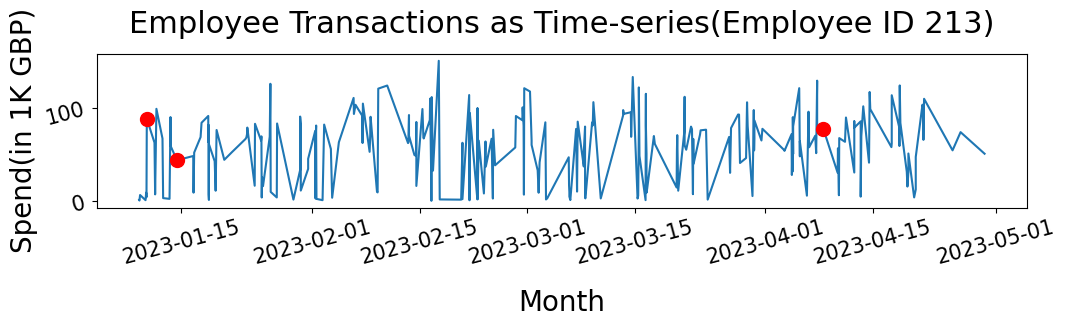

In [186]:
fig, axs = plt.subplots(1, 1, figsize=(12, 2))

d = df[df['individual_id'] == 213]
axs.plot(d['timestamp_iso8601'], d['spend'])
axs.plot(d[d['at_risk_event'] == True]['timestamp_iso8601'], d[d['at_risk_event'] == True]['spend'], marker='o', linestyle='None', color='r', markersize=10, label='Highlighted Points')
axs.set_title('Employee Transactions as Time-series(Employee ID 213)',  fontsize=22, pad=15)
axs.set_xlabel('Month',  fontsize=20, labelpad=15)
axs.set_ylabel('Spend(in 1K GBP)',  fontsize=20)
axs.tick_params(axis='both', which='major', labelsize=15, rotation=15)  # Increase tick mark size

### Bottom Employees

In [20]:
bottom_10_employees.index

Index([597, 1717, 1592, 183, 500, 1601, 1511, 1618, 904, 1703], dtype='int64', name='individual_id')

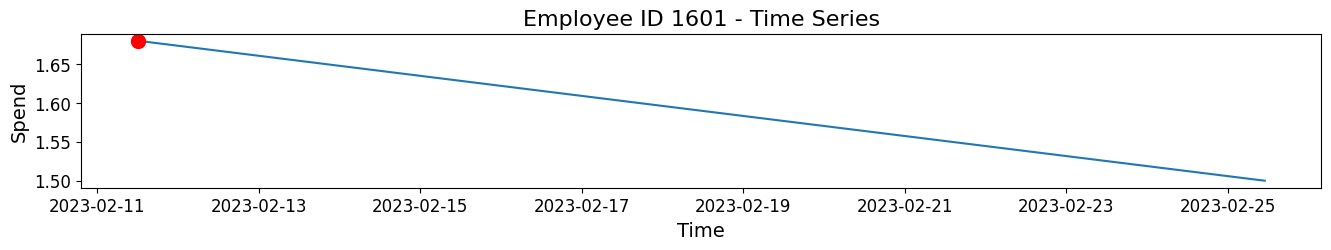

In [21]:
# plt.figure(figsize=(10, 6))
fig, axs = plt.subplots(1, 1, figsize=(16, 2))

d = df[df['individual_id'] == 1601]
axs.plot(d['timestamp_iso8601'], d['spend'])
axs.plot(d[d['at_risk_event'] == True]['timestamp_iso8601'], d[d['at_risk_event'] == True]['spend'], marker='o', linestyle='None', color='r', markersize=10, label='Highlighted Points')
axs.set_title('Employee ID 1601 - Time Series',  fontsize=16)
axs.set_xlabel('Time',  fontsize=14)
axs.set_ylabel('Spend',  fontsize=14)
axs.tick_params(axis='both', which='major', labelsize=12)  # Increase tick mark size

### Mid Employees

In [22]:
mid_employees.index

Index([616, 2023, 2085, 1883, 1658, 53, 383, 934, 1582, 2042], dtype='int64', name='individual_id')

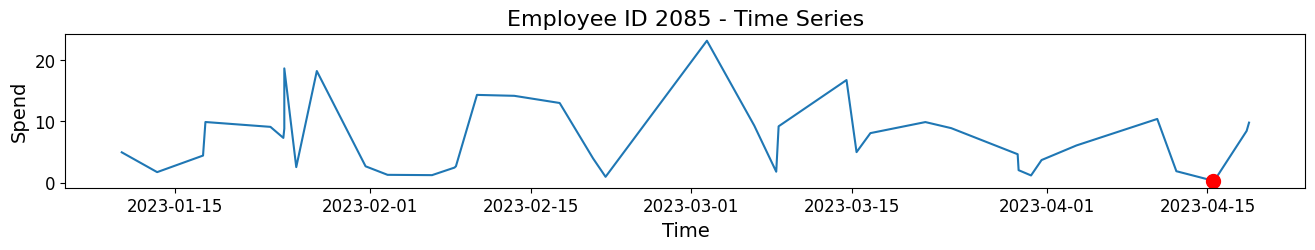

In [23]:
fig, axs = plt.subplots(1, 1, figsize=(16, 2))

d = df[df['individual_id'] == 2085]
axs.plot(d['timestamp_iso8601'], d['spend'])
axs.plot(d[d['at_risk_event'] == True]['timestamp_iso8601'], d[d['at_risk_event'] == True]['spend'], marker='o', linestyle='None', color='r', markersize=10, label='Highlighted Points')
axs.set_title('Employee ID 2085 - Time Series',  fontsize=16)
axs.set_xlabel('Time',  fontsize=14)
axs.set_ylabel('Spend',  fontsize=14)
axs.tick_params(axis='both', which='major', labelsize=12)  # Increase tick mark size

### Conclusions, Insights and Actions

Conclusions:

1. Visual analysis of top, bottom and mid spending employees plots with highlighted risky events show no particular shapelet corresponding highly to risk.

Insights:

1. Time-series specific features like shapelets, pattern dictionaries are possibly not indicative of the risk.

## Risk Impact of features corroborated by Risk Ratio

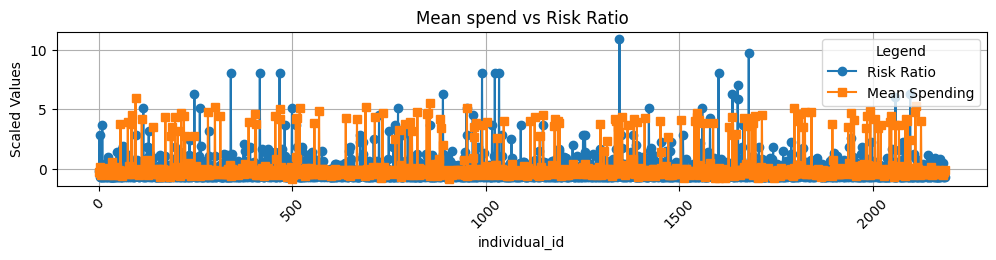

,Correlation w.r.t Risk Ratio,P-value,significant
risky_events,0.389246,5.722449e-80,True
mean_spend,0.183017,6.524781e-18,True
total_spending,-0.053074,1.309318e-02,True
total_events,-0.184303,3.799974e-18,True


In [24]:
emp_agg['risk_ratio'] = emp_agg['risky_events'] / emp_agg['total_events']
scaled_emp_agg = scale(emp_agg)
correlation_plot_and_value(scaled_emp_agg, 'individual_id')

### Date Level

104 employees with infrequent transactions dropped, as they werent contributing to the trends.

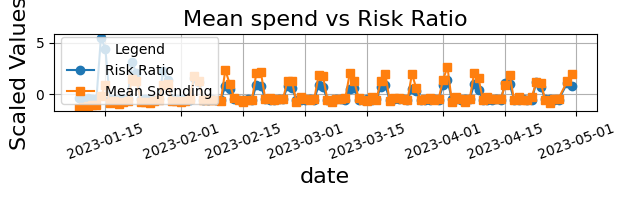

,Correlation w.r.t Risk Ratio,P-value,significant
risky_events,0.863574,3.391285e-34,True
mean_spend,0.654128,6.988679e-15,True
total_spending,-0.722241,3.690597e-19,True
total_events,-0.734048,4.940839e-20,True


In [179]:
date_agg['risk_ratio'] = date_agg['risky_events'] / date_agg['total_events']
scaled_date_agg = scale(date_agg)
correlation_plot_and_value(scaled_date_agg, 'date')

### Day Level

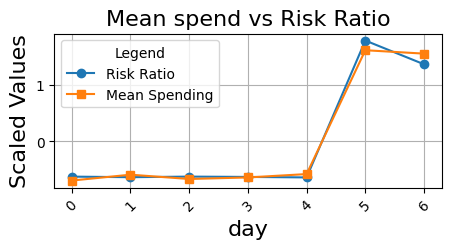

,Correlation w.r.t Risk Ratio,P-value,significant
mean_spend,0.994518,0.000004,True
risky_events,0.908325,0.004650,True
total_spending,-0.926878,0.002669,True
total_events,-0.941716,0.001526,True


In [160]:
dayofweek_agg['risk_ratio'] = dayofweek_agg['risky_events'] / dayofweek_agg['total_events']
scaled_day_agg = scale(dayofweek_agg)
correlation_plot_and_value(scaled_day_agg, 'day')

### Hour Level

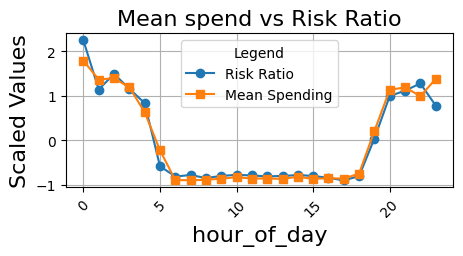

,Correlation w.r.t Risk Ratio,P-value,significant
mean_spend,0.979712,7.517938e-17,True
total_spending,-0.532779,7.352407e-03,True
total_events,-0.583579,2.757132e-03,True


In [161]:
hourofday_agg['risk_ratio'] = hourofday_agg['risky_events'] / hourofday_agg['total_events']
scaled_hour_agg = scale(hourofday_agg)
correlation_plot_and_value(scaled_hour_agg, 'hour_of_day')

### Department Level

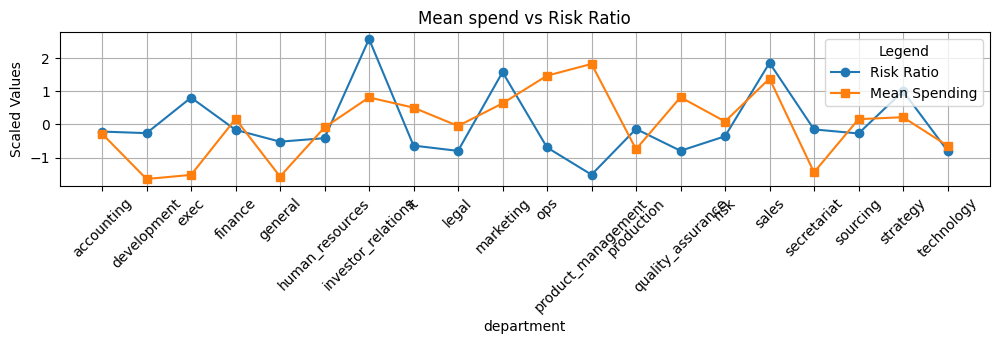

,Correlation w.r.t Risk Ratio,P-value,significant


In [28]:
department_agg['risk_ratio'] = department_agg['risky_events'] / department_agg['total_events']
scaled_dept_agg = scale(department_agg)
correlation_plot_and_value(scaled_dept_agg, 'department')

#### Conclusions, Insights and Actions

Correlations with risk_ratio

2. individual_id: weak, significant correlation with mean_spend, total_spend
3. date: moderate, significant correlation with mean_spend, total_spend
4. day_of_week: strong, significant correlation with mean_spend, total_spend
5. hour_of_day: strong, significant correlation with mean_spend, total_spend
6. department: weak, significant correlation with mean_spend, total_spend

Insights

1. Individual_id and department patterns suggest that no employee or department contributes much to risk standalone.
2. Date patterns suggest that risk depends on a few dates but not all.
3. Day_of_week and hour_of_day are highly indicative of risk.

Actions:

1. Replace individual_id and department with some derived feature more indicative of risk.
2. Find dates when the effect of risk is pronounced.

## Time-series Specific Analysis

### Trend Analysis using STL

Visualise STL of date-level aggregate dataset.

In [29]:
agg_spend_daily = date_agg['total_spending']

In [154]:
def STL_Wrapper(df, seasonal_tf, title = ""):
    stl = STL(df, period=seasonal_tf)
    result = stl.fit()

    fig, axes = plt.subplots(2, 1, figsize=(6, 3), sharex=True)

    if seasonal_tf == 7:
        axes[0].set_title("Weekly STL Analysis\nDate-aggregated dataset - "  + title, fontsize=16)
    elif seasonal_tf == 31:
        axes[0].set_title("Monthly(31 days) STL Analysis of date-aggregated dataset - " + title, fontsize=16)

    axes[0].plot(df.index, result.trend, label='Mean Spend')
    axes[0].legend(loc='upper left')
    axes[0].set_ylabel('Trend', fontsize=16)
    axes[0].tick_params(axis='both', which='major', labelsize=12)  # Increase tick mark size

    axes[1].plot(df.index, result.seasonal, label='Mean Spend', color = 'tab:red')
    axes[1].legend(loc='upper left')
    axes[1].set_ylabel('Seasonal', fontsize=16)
    axes[1].tick_params(axis='both', which='major', labelsize=12)  # Increase tick mark size

    axes[1].xaxis.set_major_locator(MonthLocator())
    axes[1].xaxis.set_minor_locator(WeekdayLocator())
    axes[1].xaxis.set_major_formatter(DateFormatter('%b %Y'))
    axes[1].tick_params(axis='both', which='major', labelsize=12)  # Increase tick mark size

    plt.subplots_adjust(bottom=0.2)
    plt.tight_layout()
    plt.show()
    
    return result

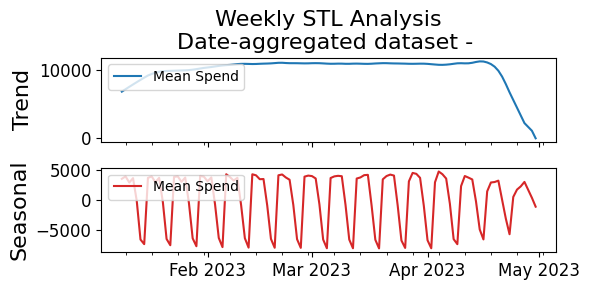

In [156]:
# Weekly STL plots
stl_weekly = STL_Wrapper(agg_spend_daily, 7)

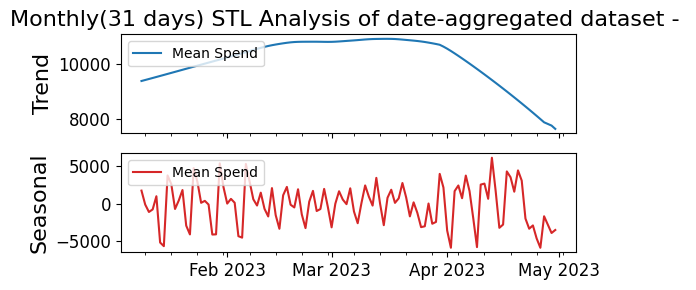

In [157]:
# Monthly
stl_weekly = STL_Wrapper(agg_spend_daily, 31)

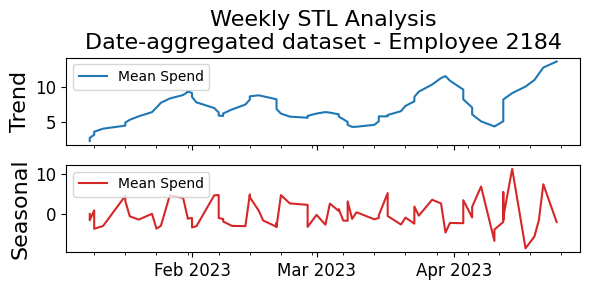

In [158]:
# A sample employee with individual_id = 2184
STL_Wrapper(df[df['individual_id'] == 2184].set_index('date')['spend'], 7, "Employee 2184")

#### Conclusions, Insights and Actions

Conclusion:

1. Weekly analysis shows flat trends and distinct seasonality, repeating weekly.
2. Monthly analysis shows smoother trends and distinct seasonality, repeating weekly.

Actions:

1. For dates where seasonality changes, perform change point techniques on seasonal trend component.

### Change Point Detection

Get change points for seasonality component for date-aggregated dataset.

In [172]:
def change_point_detection(df, time, show_graph = 1, title = ""):
    dates = []
    
    stl = STL(df, period=time)
    result = stl.fit()
    
    cpd_df = pd.DataFrame({'date': df.index, 'seasonal': result.seasonal, 'residuals': result.resid})

    seasonal_data = cpd_df['seasonal'].values.reshape(-1, 1)
    residuals_data = cpd_df['residuals'].values.reshape(-1, 1)

    # Apply change point detection using Pelt search method with BIC criterion
    model = "l1"  # "l2", "rbf", "linear", "normal", ...
    algos = rpt.Pelt(model=model, min_size=7).fit(seasonal_data)
    algor = rpt.Pelt(model=model, min_size=7).fit(residuals_data)
    outs = algos.predict(pen=10)
    outr = algor.predict(pen=10)

    if show_graph == 1:
        plt.figure(figsize=(6, 3))
        plt.plot(cpd_df['date'], cpd_df['seasonal'], label='Seasonal Component')
        for i in range(len(outs)-1):
            plt.axvline(cpd_df.iloc[outs[i], 0], color='r', linestyle='--', label=f'Change Point {i+1}')
        plt.xlabel('Time', fontsize=16)
        plt.ylabel('Seasonal', fontsize=16)
        plt.title('Change Points in Weekly STL Seasonality - ' + title, fontsize=16)
        plt.tick_params(axis='both', which='major', labelsize=14, rotation=45)
        plt.legend()
        plt.show()

    for i in range(len(outs)-1):
        dates.append(cpd_df.iloc[outs[i], 0])

    return dates # seasonal data change points

#### Date-aggregated data - Full

This will denote seasonality change for the entire organisation.

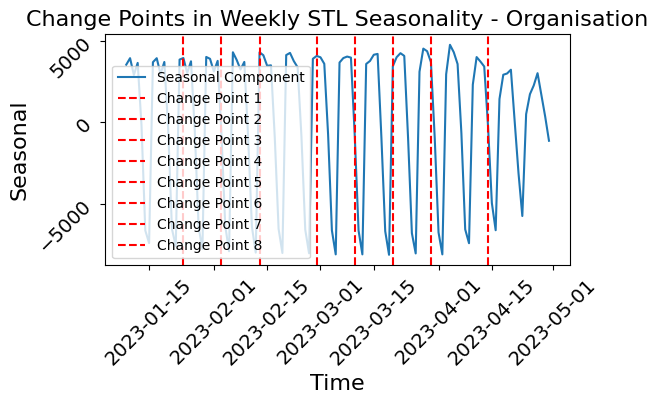

In [173]:
peak_off_dates_full = change_point_detection(agg_spend_daily, time = 7, title = "Organisation")

#### Change Point Detection - By Department

This denotes seasonality change points by department.

In [36]:
agg_daily_by_dept = df.groupby(['department', 'date']).agg({
    'spend': [('mean_spend', 'mean')]
})
agg_daily_by_dept.reset_index(inplace=True)
agg_daily_by_dept.columns = ['department', 'date', 'mean_spend']

In [37]:
peak_off_dates_by_department = {}

In [38]:
for dept in agg_daily_by_dept['department'].unique():
    d = agg_daily_by_dept[agg_daily_by_dept['department'] == dept].drop(columns = ['department'], axis = 1)
    d.set_index('date', inplace = True)
    dates = change_point_detection(d, time = 7, show_graph = 0)
    peak_off_dates_by_department[dept] = dates

#### Employee-wise Change Points

This shows change points for each employees seasonality

In [39]:
employees_with_change_points = {}
for individual in df['individual_id'].unique():
    try:
        c = change_point_detection(df[df['individual_id'] == individual].set_index('date')['spend'], time = 31, show_graph=0)
        if len(c) != 0:
            employees_with_change_points[individual] = c
    except Exception as e:
        pass

#### Conclusion, Insights and Actions

Conclusions:


1. At organisational level, significant number of change points.
2. Some departments show change points, but very less.
3. Some employees show high number of change points.

Actions:

1. Encode organisational change points as an indicator of risk by date.
2. Use count of change points per employee to indicate which employee has higher shifts in pattern.

### Stationarity Testing

In this section below, the analysis of some time-series specific characteristics like inter-employee interactions, autocorrelation etc. is done. However, for accurate analysis, it requires the time-series to be stationary. Hence, performing ADF test for stationarity.

NOTE: it is imperative that the time frequency is uniform in nature. Hence, pivot table is being used to index full date range(from 2023-01-09 to 2023-04-29) for each employee (individual_id) and aggregate data at week level for analysis.

In [40]:
# Pivot table for data completeness by date.
pivot = pd.pivot_table(df, values='spend', index='date', columns='individual_id', aggfunc='sum').fillna(0)
full_date_range = pd.date_range(start=pivot.index.min(), end=pivot.index.max(), freq='D')
pivot = pivot.reindex(full_date_range, fill_value=0)
pivot.index = pivot.index.rename('date')

Using the ADF test to check if the time series for each individual_id is stationary through the course of the year(or final transaction) or not.

In [41]:
nonstationary = []
short = []
stationary = []
for individual in df['individual_id'].unique():
    time_series = pivot[individual].values
    try:
        if adfuller(time_series)[1] < 0.05:
            nonstationary.append(individual)
        else:
            stationary.append(individual)
    except Exception as e:
        short.append(individual)
print("The number of non-stationary time-series are: ", len(nonstationary))
print("The number of time-series with issues are: ", len(short))
print("The number of stationary time-series are: ", len(df['individual_id'].unique()) - len(nonstationary) - len(short))

a:\apps\envs\lloyds\Lib\site-packages\statsmodels\regression\linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


The number of non-stationary time-series are:  2036
The number of time-series with issues are:  0
The number of stationary time-series are:  149


#### Conclusion, Insight and Actions

Conclusion:

1. A large number of employees have non-stationary or inadequate time-series.

Insight:

1. Need data transformations before applying VAR models.

### Making employee-time series stationary

take residuals for every employee time-series. Use them in place of spends.

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose_and_get_residuals(group):
    stl = STL(group['spend'], period=31)
    result = stl.fit()

    # Assign residuals to a new column
    group['residual'] = result.resid
    group['trend'] = result.trend
    group['seasonal'] = result.seasonal
    return group

# Apply the function to each group and reset index
df['individual_id2'] = df['individual_id']
df = df.groupby('individual_id2').apply(decompose_and_get_residuals, include_groups=False).reset_index(drop=True)

### Stationary Checking on Residuals

Checking stationarity after removing the effects of trends and seasonality

In [43]:
pivot2 = pd.pivot_table(df, values='residual', index='date', columns='individual_id', aggfunc='sum').fillna(0)
full_date_range = pd.date_range(start=pivot2.index.min(), end=pivot2.index.max(), freq='D')
pivot2 = pivot2.reindex(full_date_range, fill_value=0)
pivot2.index = pivot2.index.rename('date')

In [44]:
nonstationary = []
short = []
stationary = []
for individual in df['individual_id'].unique():
    time_series = pivot2[individual].values
    try:
        if adfuller(time_series)[1] < 0.05:
            nonstationary.append(individual)
        else:
            stationary.append(individual)
    except Exception as e:
        short.append(individual)
print("The number of non-stationary time-series are: ", len(nonstationary))
print("The number of time-series with issues are: ", len(short))
print("The number of stationary time-series are: ", len(df['individual_id'].unique()) - len(nonstationary) - len(short))

a:\apps\envs\lloyds\Lib\site-packages\statsmodels\regression\linear_model.py:958: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


The number of non-stationary time-series are:  1553
The number of time-series with issues are:  23
The number of stationary time-series are:  609


#### Conclusions, Insights and Actions

Conclusions:

1. Even after removing the effect of trends and seasonality, 1553 employee spends are non-stationary in nature.

Insights:

1. Models like ARIMA and VAR cannot be applied.

### Inter-Employee Correlations

Determine whether the time series is multivariate or multiple univariate.

In [45]:
# Select 200 random employees
sample = pivot.sample(n=200, axis=1)
correlation_matrix = sample.corr()
threshold = 0.7

correlated_pairs = []

# Iterate through the upper triangle of the correlation matrix
num_features = correlation_matrix.shape[0]
for i in range(num_features):
    for j in range(i + 1, num_features):
        if correlation_matrix.iloc[i, j] > threshold:
            correlated_pairs.append((correlation_matrix.index[i], correlation_matrix.columns[j]))

print("Employees with spend correlation > 0.7:")
count = 0
for pair in correlated_pairs:
    count += 1
print(count)

Employees with spend correlation > 0.7:
8


In [46]:
from sklearn.metrics import mutual_info_score

# Compute mutual information
mi = mutual_info_score(df['individual_id'].values, df['spend'].values.astype(int))

print(f"Mutual Information: {mi:.4f}")

Mutual Information: 0.4858


In [47]:
# granger causality test
from statsmodels.tsa.stattools import grangercausalitytests

test_result = grangercausalitytests(df[['individual_id', 'spend']], maxlag = 7)

for lag in range(7, 8):
    test = test_result[lag][0]['ssr_ftest']
    print(f"Lag {lag}: F-statistic = {test[0]}, p-value = {test[1]}")


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.3881 , p=0.0001  , df_denom=105238, df_num=1
ssr based chi2 test:   chi2=15.3886 , p=0.0001  , df=1
likelihood ratio test: chi2=15.3875 , p=0.0001  , df=1
parameter F test:         F=15.3881 , p=0.0001  , df_denom=105238, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.5334  , p=0.0002  , df_denom=105235, df_num=2
ssr based chi2 test:   chi2=17.0675 , p=0.0002  , df=2
likelihood ratio test: chi2=17.0661 , p=0.0002  , df=2
parameter F test:         F=8.5334  , p=0.0002  , df_denom=105235, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.9127  , p=0.0000  , df_denom=105232, df_num=3
ssr based chi2 test:   chi2=23.7396 , p=0.0000  , df=3
likelihood ratio test: chi2=23.7369 , p=0.0000  , df=3
parameter F test:         F=7.9127  , p=0.0000  , df_denom=105232, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.

#### Conclusions, Insights, Actions and Limitations

Conclusions:

1. Many employees found with moderately correlated time-series, and some of them highly correlated.
2. P-value < 0.05. Hence, Granger causality test shows definite proof of interaction between employees and spends.
   
Insight:

1. The time series is multivariate, and not multiple univariate.
2. Models like VAR, which can capture interations between multivariate time-series need to be explored. ARIMA models are not applicable.

Actions:

1. Perform Autocorrelation analysis.

### Autocorrelation Testing

Autocorrelation plots for the average ACF values for all employees as lag 7

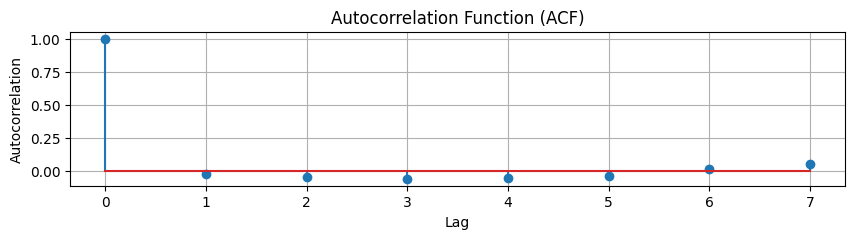

In [48]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt

acf_values_all = []
for individual in pivot.columns:
    acf_values, confint = acf(pivot[individual], nlags = 7, fft=False, alpha=0.05)
    acf_values_all.append(acf_values)

acf_mean = np.mean(np.array(acf_values_all), axis = 0)

lags = np.arange(len(acf_mean))

# Plot the autocorrelation values
plt.figure(figsize=(10, 2))
markerline, stemlines, baseline = plt.stem(lags, acf_mean)
plt.setp(stemlines, 'color', plt.getp(markerline, 'color'))  # Match stemlines color to markerline
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.grid(True)
plt.show()

#### Conclusions, Insight and Actions

Conclusions:

1. The ACF plot show very less autocorrelation (on an average) for all employees.

Insight:

1. Features considering lags like rolling mean etc. would not contribute to the risk.

# Feature Engineering

1. Global time series features for individual_id and department - apex results.
2. STL or equivalent to get capture variation in dates
   - change points per employee.

In [49]:
# Feature Engineering 1

# global feature - individuals
individual_approximation = df.groupby(['individual_id', 'day_of_week', 'hour_of_day'])['spend'].mean()
individual_approximation = individual_approximation.to_frame().reset_index()
individual_approximation.columns = ['individual_id', 'day_of_week', 'hour_of_day', 'ind_spend_approx']

df = pd.merge(df, individual_approximation, on=['individual_id', 'day_of_week', 'hour_of_day'], how='left')

# global feature - department
department_approximation = df.groupby(['department', 'day_of_week', 'hour_of_day'])['spend'].mean()
department_approximation = department_approximation.to_frame().reset_index()
department_approximation.columns = ['department', 'day_of_week', 'hour_of_day', 'dep_spend_approx']

df = pd.merge(df, department_approximation, on=['department', 'day_of_week', 'hour_of_day'], how='left')

In [50]:
# Feature Engineering 2 - 1

df['change_point_count'] = 0
for k, v in employees_with_change_points.items():
    df.loc[df['individual_id'] == k, 'change_point_count'] = len(v)

# Data Modelling

## Dataset Preparation

In [51]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

spending_aggregates = df.groupby(['individual_id']).agg({
    'spend': [('total_spend', 'sum'), ('total_events', 'count')],
    'change_point_count': [('change_freq', 'mean')]
})
spending_aggregates.columns = [col[1] for col in spending_aggregates.columns]
spending_aggregates.reset_index(inplace=True)
features = spending_aggregates[['total_spend', 'total_events', 'change_freq']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Cluster employees into different groups based on total spend, total events and change point count
# for efficient splitting into train-test splits

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(features_scaled)

spending_aggregates['cluster'] = dbscan.labels_

if 'cluster' not in df.columns:
    df = df.merge(spending_aggregates[['individual_id', 'cluster']], on=['individual_id'], how='left')

In [52]:
dataset = df[['individual_id', 'day_of_week', 'hour_of_day', 'ind_spend_approx', 'dep_spend_approx', 'seasonal', 'spend', 'at_risk_event', 'cluster']]

cols_not_to_scale = dataset[['individual_id', 'day_of_week', 'hour_of_day', 'at_risk_event', 'cluster']]
cols_to_scale = dataset.drop(columns = ['individual_id', 'at_risk_event', 'hour_of_day', 'day_of_week', 'cluster'], axis=1)

scaler = MinMaxScaler()
scaled_dataset = pd.DataFrame(scaler.fit_transform(cols_to_scale), columns=cols_to_scale.columns)
scaled_dataset = pd.concat([cols_not_to_scale, scaled_dataset], axis = 1)

In [53]:
train_list, test_list = [], []

# split the dataset into train-test using precomputed clusters
# train part gets 80% of employees in each cluster
# such that train and test are equally representative 

for cluster in scaled_dataset['cluster'].unique():
    employees = scaled_dataset[scaled_dataset['cluster'] == cluster]['individual_id'].unique()
    if len(employees) < 10:
        train_list.append(scaled_dataset[scaled_dataset['individual_id'].isin(employees)])
    else:
        random.shuffle(employees)
        train_size = int(0.8 * len(employees))
        train_employees = employees[:train_size]
        test_employees = employees[train_size:]
        train_list.append(scaled_dataset[scaled_dataset['individual_id'].isin(train_employees)])
        test_list.append(scaled_dataset[scaled_dataset['individual_id'].isin(test_employees)])

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [54]:
if 'individual_id' in train_df.columns and 'cluster' in train_df.columns:
    train_df.drop(columns = ['individual_id', 'cluster'], inplace=True)
if 'individual_id' in test_df.columns and 'cluster' in test_df.columns:
    test_df.drop(columns = ['individual_id', 'cluster'], inplace=True)

X_train = train_df.drop(columns = ['at_risk_event', 'spend'])
y_train = pd.DataFrame(train_df, columns=['spend'])
X_test = test_df.drop(columns = ['at_risk_event', 'spend'])
y_test = pd.DataFrame(test_df, columns=['spend'])
labels_train = pd.DataFrame(train_df['at_risk_event'], columns=['at_risk_event'])
labels_test = pd.DataFrame(test_df['at_risk_event'], columns=['at_risk_event'])

## Auxiliary Functions

In [55]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

In [56]:
def results(y_true, y_pred, model_name):
    print("Results:")
    print(classification_report(y_true, y_pred))
    plot_confusion_matrix(y_true, y_pred, 'Confusion Matrix - ' + model_name)

## Data Modelling

### Polynomial Regression

Results:
              precision    recall  f1-score   support

       False       0.98      0.97      0.97     20948
        True       0.06      0.06      0.06       557

    accuracy                           0.95     21505
   macro avg       0.52      0.52      0.52     21505
weighted avg       0.95      0.95      0.95     21505



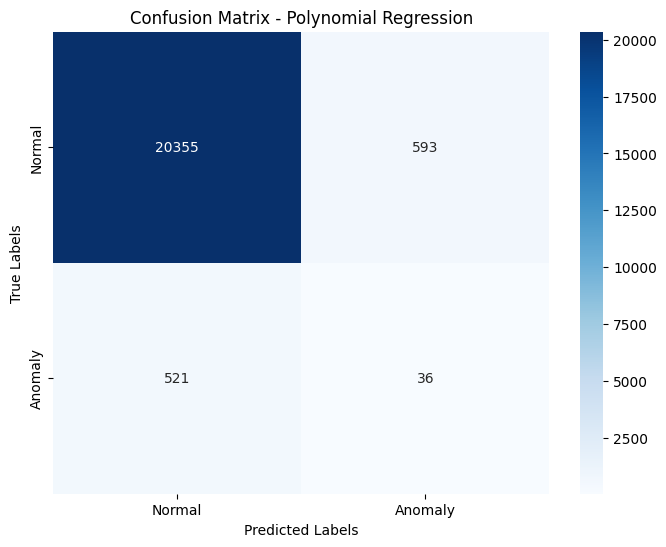

CPU times: total: 46.9 ms
Wall time: 269 ms


In [57]:
%%time

# baseline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# training and data
# X - all features from dataframe 'dataset' except spend, cluster and at_risk_event.
# y - spend values
model_polyreg = make_pipeline(PolynomialFeatures(2), LinearRegression())
model_polyreg.fit(X_train, y_train)

y_pred = model_polyreg.predict(X_test)
residuals = y_test - y_pred

threshold = np.mean(residuals.values) + 2*np.std(residuals.values)

results(labels_test, residuals > threshold, 'Polynomial Regression')

### One-Class SVM

params are  {'kernel': 'rbf', 'gamma': 'scale', 'nu': 0.03, 'shrinking': True}
params are  {'kernel': 'rbf', 'gamma': 'scale', 'nu': 0.05, 'shrinking': True}
Best parameters found:  {'kernel': 'rbf', 'gamma': 'scale', 'nu': 0.05, 'shrinking': True}
Best F1 Score:  0.19981041397307364
Results:
              precision    recall  f1-score   support

       False       0.99      0.91      0.95     20948
        True       0.13      0.48      0.20       557

    accuracy                           0.90     21505
   macro avg       0.56      0.70      0.57     21505
weighted avg       0.96      0.90      0.93     21505



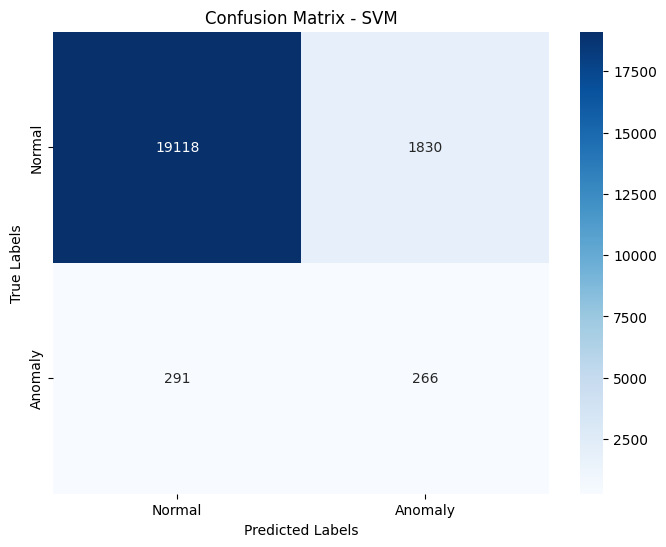

CPU times: total: 1min 4s
Wall time: 5min 27s


In [58]:
%%time

# training and data - all columns from dataframe dataset except cluster and at_risk_event.
# testing on test labels

X_train_svm = pd.concat([X_train, y_train], axis = 1)
X_test_svm = pd.concat([X_test, y_test], axis = 1)

# Define the parameter grid for Isolation Forest
param_grid = {
    'gamma': ['scale'],
    'nu': [0.03, 0.05]
}

# Function to evaluate the model
def evaluate_model(params, X, y, cv):
    f1_scores = []
    for train_index, val_index in cv.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model = OneClassSVM(**params)
        model.fit(X_train)
        y_pred = model.predict(X_val)
        score = f1_score(y_val, y_pred, pos_label=-1)
        f1_scores.append(score)
    
    return np.mean(f1_scores)

# Define the cross-validation strategy
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform manual grid search with cross-validation
best_score = -np.inf
best_params = None

for gamma in param_grid['gamma']:
    for nu in param_grid['nu']:
        params = {
            'kernel': 'rbf',
            'gamma': gamma,
            'nu': nu,
            'shrinking': True,
        }
        print("params are ", params)
        mean_f1_score = evaluate_model(params, X_train_svm.values, np.where(labels_train, -1, 1).flatten(), kf)
        if mean_f1_score > best_score:
            best_score = mean_f1_score
            best_params = params

print("Best parameters found: ", best_params)
print("Best F1 Score: ", best_score)

model_svm = OneClassSVM(kernel='rbf', gamma=0.1, nu=0.1)
model_svm.fit(X_train_svm)

predicted_labels_svm = (model_svm.predict(X_test_svm) == -1)
results(labels_test, predicted_labels_svm, 'SVM')

### Isolation Forest

{'n_estimators': 50, 'max_samples': 'auto', 'contamination': 'auto'}
{'n_estimators': 100, 'max_samples': 'auto', 'contamination': 'auto'}
{'n_estimators': 150, 'max_samples': 'auto', 'contamination': 'auto'}
{'n_estimators': 1000, 'max_samples': 'auto', 'contamination': 'auto'}
Best parameters found:  {'n_estimators': 50, 'max_samples': 'auto', 'contamination': 'auto'}
Best F1 Score:  0.22863274218425103
Results:
              precision    recall  f1-score   support

       False       0.99      0.88      0.93     20948
        True       0.13      0.64      0.21       557

    accuracy                           0.88     21505
   macro avg       0.56      0.76      0.57     21505
weighted avg       0.97      0.88      0.91     21505



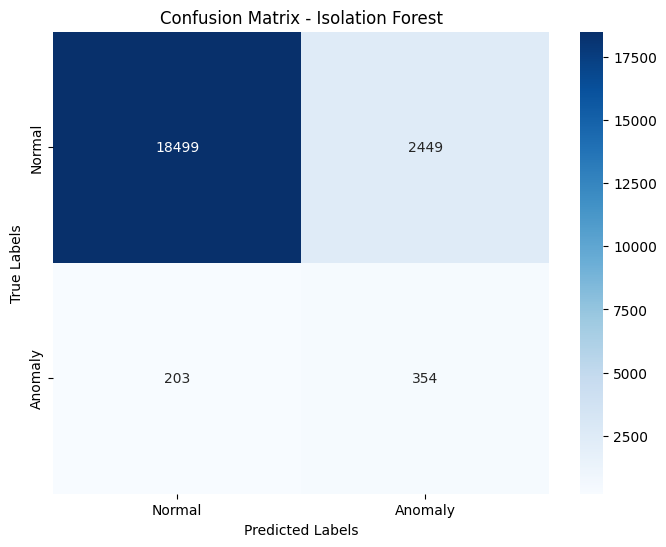

CPU times: total: 6.92 s
Wall time: 38.1 s


In [59]:
%%time

import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

# Define the parameter grid for Isolation Forest
param_grid = {
    'n_estimators': [50, 100, 150, 1000],
    'max_samples': ['auto'],
    'contamination': ['auto']
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def evaluate(params, X, y, cv):
    f1_scores = []
    for train_index, val_index in cv.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model = IsolationForest(**params, random_state = 42, n_jobs = -1)
        model.fit(X_train)
        y_pred = model.predict(X_val)
        score = f1_score(y_val, y_pred, pos_label=-1)
        f1_scores.append(score)
    
    return np.mean(f1_scores)

# training and testing data - all columns from dataframe dataset except cluster and at_risk_event
X_train_if = pd.concat([X_train, y_train], axis = 1)
X_test_if = pd.concat([X_test, y_test], axis = 1)

# Perform manual grid search with cross-validation
best_score = -np.inf
best_params = None

for n_estimators in param_grid['n_estimators']:
    for max_samples in param_grid['max_samples']:
        for contamination in param_grid['contamination']:
            params = {
                'n_estimators': n_estimators,
                'max_samples': max_samples,
                'contamination': contamination
            }
            print(params)
            mean_f1_score = evaluate(params, X_train_if.values, np.where(labels_train, -1, 1).flatten(), kf)
            if mean_f1_score > best_score:
                best_score = mean_f1_score
                best_params = params

print("Best parameters found: ", best_params)
print("Best F1 Score: ", best_score)

model_if = IsolationForest(**best_params)
model_if.fit(X_train_if.values)

predicted_labels_if = (model_if.predict(X_test_if.values) == -1)
results(labels_test, predicted_labels_if, 'Isolation Forest')

### PCA

Results:
              precision    recall  f1-score   support

       False       0.98      0.96      0.97     20948
        True       0.18      0.37      0.24       557

    accuracy                           0.94     21505
   macro avg       0.58      0.66      0.61     21505
weighted avg       0.96      0.94      0.95     21505



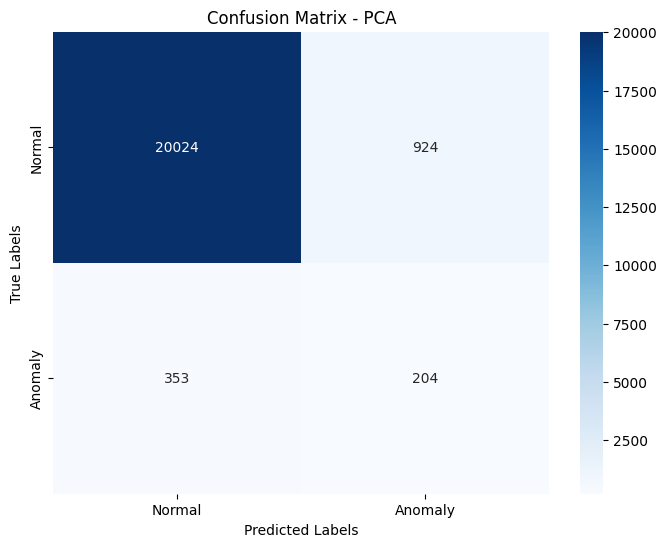

CPU times: total: 766 ms
Wall time: 2.38 s


In [60]:
%%time

from sklearn.decomposition import PCA

# Testing data - all columns from the dataframe dataset, excluding cluster and at_risk_event.
data = X_test.values
pca = PCA(n_components = 3)
pca.fit(data)

reconstruction_errors = np.zeros(data.shape[0])

for i, sample in enumerate(data):
    reconstructed_sample = pca.inverse_transform(pca.transform(sample.reshape(1, -1)))
    reconstruction_errors[i] = np.linalg.norm(sample - reconstructed_sample)

threshold = np.mean(reconstruction_errors) + 2 * np.std(reconstruction_errors)

results(labels_test, reconstruction_errors > threshold, 'PCA')